In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import svm, preprocessing
from sklearn.cluster import KMeans

from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Plot the raw training data

Sample size 394


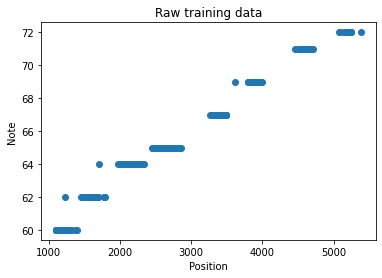

In [21]:
samples, labels = np.loadtxt('training_data.csv', delimiter=',', dtype=int)
notes = [60,62,64,65,67,69,71,72]

print("Sample size", len(samples))
plt.scatter(samples, labels)
plt.title('Raw training data')
plt.xlabel('Position')
plt.ylabel('Note')
plt.show()

# Remove bad training sample by K-Means

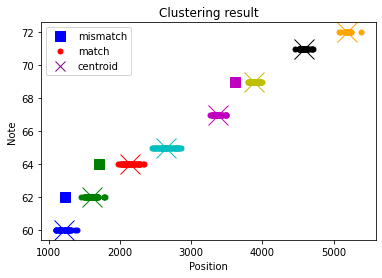

removed note 62 position 1234 from training data set
removed note 64 position 1700 from training data set
removed note 69 position 3621 from training data set


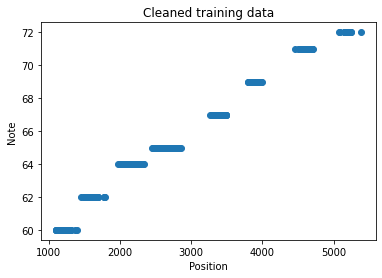

Sample size: 391


In [11]:
km = KMeans(n_clusters=8)
km.fit(samples.reshape(-1,1))
centroids = sorted(km.cluster_centers_)
centroid_labels = list(km.predict(centroids))
colors = ["b","g","r","c","m","y","k","orange"]

prediction = km.predict(samples.reshape(-1,1))
mispredicted = []
for i in range(len(samples)):
    predicted_note_index = centroid_labels.index(prediction[i])
    predicted_note = notes[predicted_note_index]
    actual = labels[i]
    if predicted_note != actual:
        plt.plot(samples[i], actual, colors[predicted_note_index], marker='s', markersize = 10)
        mispredicted += [i]
    else:
        plt.plot(samples[i], actual, colors[predicted_note_index], marker='.', markersize = 10)

for i in range(len(centroids)):
    plt.plot(centroids[i], notes[i], colors[i], marker='x', markersize = 20)


plt.title('Clustering result')
plt.xlabel('Position')
plt.ylabel('Note')

h1 = mlines.Line2D([], [], color='blue', marker='s', linestyle='None',
                        markersize=10, label='mismatch')
h2 = mlines.Line2D([], [], color='red', marker='.', linestyle='None',
                        markersize=10, label='match')
h3 = mlines.Line2D([], [], color='purple', marker='x', linestyle='None',
                        markersize=10, label='centroid')
plt.legend(handles=[h1,h2,h3])
plt.show()

samples = list(samples)
labels = list(labels)
for m in mispredicted[::-1]:
    p = samples.pop(m)
    l = labels.pop(m)
    print(f'removed note {l} position {p} from training data set')
samples = np.array(samples)
labels = np.array(labels)


plt.scatter(samples, labels)
plt.title('Cleaned training data')
plt.xlabel('Position')
plt.ylabel('Note')
plt.show()
print("Sample size:", len(samples))


# Proprocessing

In [12]:
enc = preprocessing.LabelEncoder()
enc.fit(labels)
encoded_labels = enc.transform(labels)
train_samples, test_samples, train_labels, test_labels = train_test_split(samples,encoded_labels, test_size=0.02, random_state=20)
train_labels,train_samples=shuffle(train_labels,train_samples)
test_labels,test_samples=shuffle(test_labels,test_samples)


# Predict with NN

In [13]:
#Model
model=Sequential([Dense(units=64,input_shape=(1,),activation='relu'),
                 Dense(units=32,activation='relu'),
                 Dense (units=8,activation='softmax')])

#Training
model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x=train_samples,y=train_labels,epochs=3000,validation_data=(test_samples, test_labels),verbose=1)
model.summary()

Epoch 1/3000
12/12 [==============================] - 0s 13ms/step - loss: 516.4123 - accuracy: 0.1201 - val_loss: 243.8897 - val_accuracy: 0.2500
Epoch 2/3000
12/12 [==============================] - 0s 3ms/step - loss: 264.2246 - accuracy: 0.1175 - val_loss: 116.5227 - val_accuracy: 0.2500
Epoch 3/3000
12/12 [==============================] - 0s 3ms/step - loss: 125.5100 - accuracy: 0.1018 - val_loss: 54.8414 - val_accuracy: 0.2500
Epoch 4/3000
12/12 [==============================] - 0s 3ms/step - loss: 59.7105 - accuracy: 0.1097 - val_loss: 52.9814 - val_accuracy: 0.0000e+00
Epoch 5/3000
12/12 [==============================] - 0s 3ms/step - loss: 36.9679 - accuracy: 0.1149 - val_loss: 39.7695 - val_accuracy: 0.0000e+00
Epoch 6/3000
12/12 [==============================] - 0s 3ms/step - loss: 20.6458 - accuracy: 0.1305 - val_loss: 32.8013 - val_accuracy: 0.0000e+00
Epoch 7/3000
12/12 [==============================] - 0s 3ms/step - loss: 12.3903 - accuracy: 0.1279 - val_loss: 26.21

# Plot Results

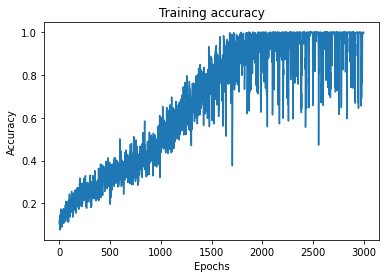

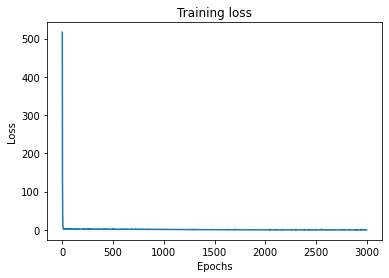

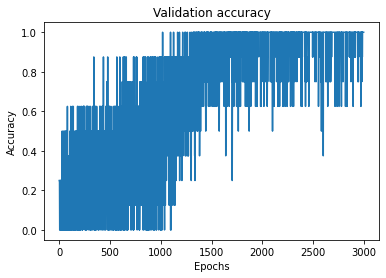

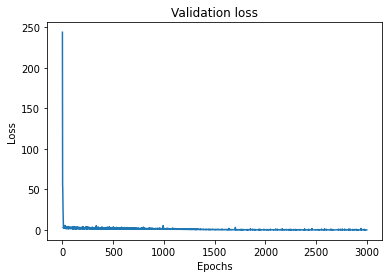

In [14]:
#Plot graph
plt.plot(history.history['accuracy'])
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(history.history['loss'])
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


plt.plot(history.history['val_loss'])
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Classify by SVM

In [15]:
from sklearn import svm
svc = svm.SVC()
svc.fit(train_samples.reshape(-1,1), train_labels)


SVC()

# Visualize Classifier

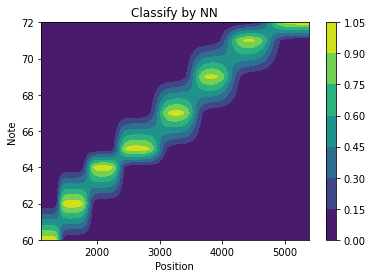

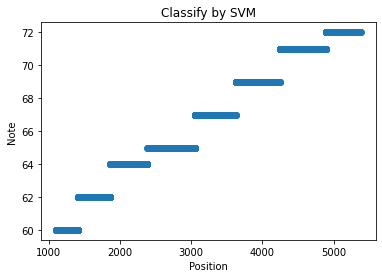

In [16]:
step=1
xs = np.arange(samples.min(), samples.max(), step)
output = model.predict(xs)
c = plt.contourf(xs, notes , output.T)
plt.colorbar(c)
plt.title('Classify by NN')
plt.xlabel('Position')
plt.ylabel('Note')
plt.show()

output = svc.predict(xs.reshape(-1,1))
output = enc.inverse_transform(output)
plt.scatter(xs, output)
plt.title('Classify by SVM')
plt.xlabel('Position')
plt.ylabel('Note')
plt.show()

# Save the training model

In [17]:
#Save model
model.save("trained_model.h5")
#Load .h5 model and predict
model = load_model('trained_model.h5')

# Load Midi file

In [60]:
import mido
f = mido.MidiFile('1.mid')
midi_notes = list(map(lambda x: x.note, filter(lambda x : x.velocity == 80, f.tracks[0][11:-1])))
print('Loaded', len(midi_notes), 'notes')
print(midi_notes)

Loaded 26 notes
[64, 62, 60, 62, 64, 64, 64, 62, 62, 62, 64, 67, 67, 64, 62, 60, 62, 64, 64, 64, 64, 62, 62, 64, 62, 60]


# Fit decision tree classifier

In [82]:
from sklearn import tree
t = tree.DecisionTreeClassifier()

def pad_seq(seq, win_size_max):
    return seq + [0]*(win_size_max-len(seq))
# build list of possible note transistion
win_size_max = 3
song_len = len(midi_notes)
transitions = []
nexts = []
for window_size in range(1, win_size_max+1):
    for base in range(song_len-window_size):
        window = midi_notes[base:base+window_size] + [0] * (win_size_max-window_size)
        next = midi_notes[base+window_size]
        transitions += [window]
        nexts += [next]

t.fit(transitions, nexts)

seq = pad_seq([60], win_size_max)
prob = t.predict_proba([seq])
print('given sequence', seq, 'next notes are' , t.classes_, 'with prob', prob)

seq = pad_seq([64, 62], win_size_max)
prob = t.predict_proba([seq])
print('given sequence', seq, 'next notes are' , t.classes_, 'with prob', prob)



given sequence [60, 0, 0] next notes are [60 62 64 67] with prob [[0. 1. 0. 0.]]
given sequence [62, 64, 0] next notes are [60 62 64 67] with prob [[0.   0.25 0.5  0.25]]


# Predict next note with NN

In [81]:
seq = pad_seq([64, 62], win_size_max)
press_pos = 2000 # between 62 and 64, but 64 is not possible

dt_prob = [0 for _ in range(len(notes))]
dt_pred = t.predict_proba([seq])[0]
for c in t.classes_:
    idx = np.where(t.classes_ == c)
    # idx = t.classes_.where(c)
    prob = dt_pred[idx][0]
    idx = notes.index(c)
    dt_prob[idx] = prob

dt_prob = np.array(dt_prob)
nn_prob = model.predict([press_pos])[0]
cm_prob = dt_prob * nn_prob

print('Notes:')
print(notes)
print('Prediction with decision tree')
print(dt_prob)
print('Prediction with neural network')
print(nn_prob)
print('Combined prediction')
print(cm_prob)
print('Predicted note is', notes[np.argmax(cm_prob)])

Notes:
[60, 62, 64, 65, 67, 69, 71, 72]
Prediction with decision tree
[0.6 0.4 0.  0.  0.  0.  0.  0. ]
Prediction with neural network
[2.8862438e-12 3.0362697e-02 9.6897328e-01 6.6402456e-04 3.6404038e-10
 2.1703730e-19 8.2994934e-30 0.0000000e+00]
Combined prediction
[1.73174626e-12 1.21450789e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Predicted note is 62
